# Capstone: West Nile Virus Challenge
 
West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given weather, location, testing, and spraying data, we are asked to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns',1000)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, make_scorer, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn import naive_bayes
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from datetime import date

import tensorflow as tf

from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import display
from IPython.display import Image

import pickle
from tkinter import Tk
from tkinter.filedialog import askopenfilename

import pylab as plt

## Data Loading and Cleaning

### Training and Test data:
The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set we are requested 
to predict the test results for 2008, 2010, 2012, and 2014.

In [2]:
train = pd.read_csv('./datasets/train.csv')

# Make Date into datetime object, and index:
train['Date'] = pd.to_datetime(train.Date, format='%Y-%m-%d')
train.set_index('Date', inplace=True, drop=True)
train.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


We make a note here of the baseline to be bettered through modelling:

In [3]:
print('Baseline = {}'.format(train.WnvPresent.value_counts(normalize=True).max()))
train.WnvPresent.value_counts()

# we can see clearly the problem: only 5% of those traps inspected carried Wnv, can we improve on this?
# we also see a class imbalance here that will need to be resolved before modelling

Baseline = 0.9475537787930707


0    9955
1     551
Name: WnvPresent, dtype: int64

In [4]:
test = pd.read_csv('./datasets/test.csv')
# Make Date into datetime object, and index
test['Date'] = pd.to_datetime(test.Date, format='%Y-%m-%d')
test.set_index('Date', inplace=True, drop=True)
test.head(1)

,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Date,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


### Weather Data:
It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. 
We are provided with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of
the tests. 
    Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
    Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [5]:
weather = pd.read_csv('./datasets/weather.csv')

In [6]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [7]:
weather = pd.read_csv('./datasets/weather.csv')
# Make Date into datetime object, and index
weather['Date'] = pd.to_datetime(weather.Date, format='%Y-%m-%d')
weather.set_index('Date', inplace=True, drop=True)

# Data Cleaning:
weather['Tavg'] = pd.to_numeric(weather.apply(lambda x: (x['Tmin']+x['Tmax'])/2, axis=1))
weather['PrecipTotal'] = pd.to_numeric(weather.apply(lambda x: 0 if x['PrecipTotal']=='  T' or x['PrecipTotal']=='M' else x['PrecipTotal'], axis=1))


# Add Long / Lat:
weather.insert(1,'Latitude', weather.apply(lambda x: 41.995 if x['Station']==1 else 41.786, axis=1))
weather.insert(2,'Longitude', weather.apply(lambda x: -87.933 if x['Station']==1 else -87.752, axis=1))

weather.head(1)

,Station,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2


In [8]:
# Reformatting weather data into flattened version for merging with train data:
weather_station_1 = weather[weather['Station']==1]
weather_station_2 = weather[weather['Station']==2]

weather_df = weather_station_1.merge(weather_station_2,
                                     how='inner',
                                     on='Date',
                                     suffixes=('_station_1','_station_2'))

weather_df.head(1)

,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2,2,41.786,-87.752,84,52,68.0,M,51,57,0,3,-,-,,M,M,M,0.0,29.18,29.82,2.7,25,9.6


#### PCA
Many weather features to comprehend, some of which are highly correlated as evidenced by the heatmap.
We will use the cumulated explained_variance_ratio to test this

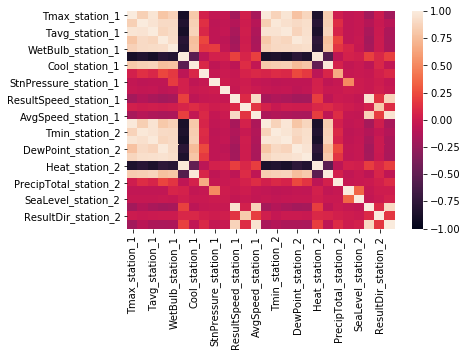

In [9]:
# Prepare a weather_pca dataframe with string dtypes converted to numeric, and standardise:
weather_pca = weather_df.drop(columns=['Station_station_1','Station_station_2',
                                       'Latitude_station_1','Longitude_station_1',
                                       'Latitude_station_2','Longitude_station_2',
                                       'Depth_station_1','Water1_station_1',
                                       'Depth_station_2','Water1_station_2',
                                       'Sunrise_station_1','Sunset_station_1',
                                       'Sunrise_station_2','Sunset_station_2',
                                       'Depart_station_1','Depart_station_2',
                                       'SnowFall_station_1','SnowFall_station_2',
                                       'CodeSum_station_1','CodeSum_station_2']).replace({'M':0,'  T':0, '-':0}).apply(pd.to_numeric)
scaler = StandardScaler()
weather_pca = pd.DataFrame(scaler.fit_transform(weather_pca), columns=weather_pca.columns)

# Check heatmap for any correlations that would be helped with PCA:
sns.heatmap(weather_pca.corr(), vmin=-1, vmax=1);

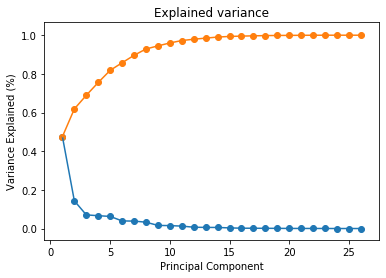

In [10]:
# Fit PCA model and assess:
pca = PCA()
pca.fit(weather_pca)

# Plot the explained_variance_ratio_
x_values = list(range(1, pca.n_components_+1))
plt.plot(x_values, pca.explained_variance_ratio_)
plt.scatter(x_values, pca.explained_variance_ratio_)
plt.plot(x_values, np.cumsum(pca.explained_variance_ratio_))
plt.scatter(x_values, np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.show()

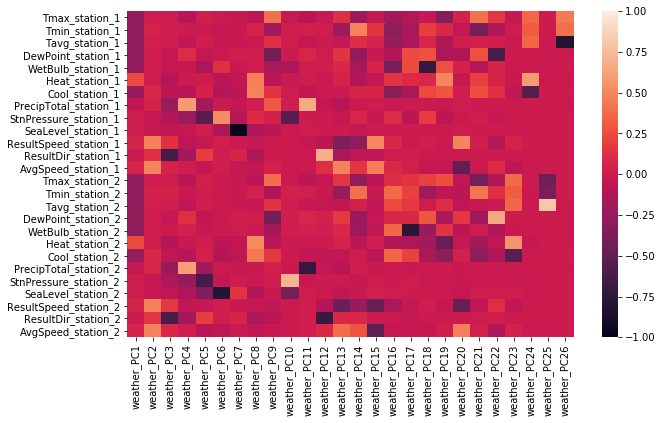

In [11]:
weather_dict = {'weather_PC'+str(i+1): pca.components_[i] for i in range(len(pca.components_))}
weather_pca_df = pd.DataFrame(weather_dict, index=weather_pca.columns)

weather_pcs = pd.DataFrame(pca.transform(weather_pca),
                           columns=['weather_PC'+str(i+1) for i in range(len(weather_pca.columns))],
                           index=weather_df.index)
plt.figure(figsize=(10,6))
sns.heatmap(weather_pca_df, vmin=-1, vmax=1, );

### Spray Data

The City of Chicago also does spraying to kill mosquitos. We are given the GIS data for their spray efforts
in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus.

In [12]:
spray = pd.read_csv('./datasets/spray.csv')
spray['Time'] = spray['Time'].fillna(value=spray.mode().Time[0])
spray['DateTime'] = spray.apply(lambda x: str(x['Date'])+' '+str(x['Time']), axis=1)
spray['DateTime'] = spray.apply(lambda x: datetime.strptime(str(x['DateTime']), '%Y-%m-%d %I:%M:%S %p'), axis=1)
spray['Date'] = spray.apply(lambda x: datetime.strptime(str(x['Date']), '%Y-%m-%d'), axis=1)
spray['Latitude2'] = np.round(spray.Latitude,2)
spray['Longitude2'] = np.round(spray.Longitude,2)
spray.set_index('DateTime', inplace=True, drop=True)
spray_df = spray.drop_duplicates(subset=['Date','Latitude2','Longitude2'])

## EDA: visualise and analyse data

### Prepare train, test dataframes

In [13]:
# Merging weather data onto train,test data:
train_df = train.merge(weather_df, how='left', on='Date', suffixes=('',''))
test_df = test.merge(weather_df, how='left', on='Date', suffixes=('',''))
# Merging weather_pcs data onto train,test data:
train_df = train_df.merge(weather_pcs, how='left', on='Date', suffixes=('',''))
test_df = test_df.merge(weather_pcs, how='left', on='Date', suffixes=('',''))
# Merging spray data onto train,test data:
    # Creating approx. lat,lon co-ordinates to match spray_df
train_df['Latitude2'] = np.round(train_df.Latitude,2)
train_df['Longitude2'] = np.round(train_df.Longitude,2)
test_df['Latitude2'] = np.round(test_df.Latitude,2)
test_df['Longitude2'] = np.round(test_df.Longitude,2)
    # Merge with spray_df
train_df = train_df.merge(spray_df, how='left', on=['Date','Latitude2','Longitude2'], suffixes=('','_spray'))
train_df['isSpray'] = [0 if x==0 else 1 for x in train_df.Time.fillna(value=0)]
train_df.set_index('Date', inplace=True, drop=True)
test_df = test_df.merge(spray_df, how='left', on=['Date','Latitude2','Longitude2'], suffixes=('','_spray'))
test_df['isSpray'] = [0 if x==0 else 1 for x in test_df.Time.fillna(value=0)]
test_df.set_index('Date', inplace=True, drop=True)

### Autocorrelation: investigating seasonality
Plotting Partial Autocorrelation for number of mosquitos found in traps shows little seasonal effects that can be leveraged in predictions

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

weather_df['Tavg_station_1'].plot(ax=ax[0], title='Temperature time series')
plot_acf(train_df['NumMosquitos'], lags=700, ax=ax[1])
plot_pacf(train_df['NumMosquitos'], lags=700, ax=ax[2])

plt.tight_layout()
plt.show()

### Scatter plots

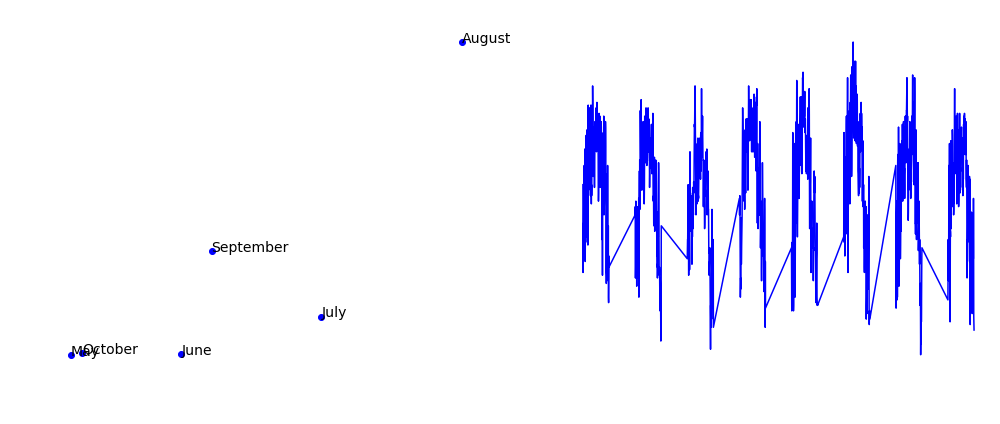

In [43]:
train_month_grp = train.groupby(train.index.month_name()).agg({'WnvPresent':'sum',
                                                        'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                            ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(14,6))

ax[0].scatter(train_month_grp['NumMosquitos'], train_month_grp['WnvPresent'], c='b');
for i, xi in enumerate(train_month_grp.index):
    ax[0].annotate(xi, (train_month_grp.iloc[i,1], train_month_grp.iloc[i,0]), fontsize=14, c='k')
ax[0].set_xlabel('NumMosquitos:sum', fontsize=14)
ax[0].set_ylabel('WnvPresent:sum', fontsize=14)
ax[0].set_title('Months with highest Wnv incidence', fontsize=18)
ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].title.set_color('white')

# ax[0].scatter(train_trap_grp['NumMosquitos'], train_trap_grp['WnvPresent'], c='w');
# for i, xi in enumerate(train_trap_grp.index[0:6]):
#     ax[0].annotate(xi, (train_trap_grp.iloc[i,1], train_trap_grp.iloc[i,0]), fontsize=12, c='w')
# ax[0].set_xlabel('NumMosquitos:sum', fontsize=10)
# ax[0].set_ylabel('WnvPresent:sum', fontsize=10)
# ax[0].set_title('Traps with highest Wnv incidence', fontsize=16)
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')

weather_df['Tavg_station_1'].plot(ax=ax[1], c='b')
ax[1].set_title('Chicago Weather', fontsize=18)
ax[1].set_ylabel('Temperature', fontsize=14)
ax[1].set_xlabel('Date', fontsize=14)
ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].title.set_color('white')

ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('white')
ax[0].spines['left'].set_color('white')
ax[0].spines['right'].set_color('white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[1].spines['right'].set_color('white')

plt.tight_layout()
fig.savefig('weather_seasonality.png', transparent=True)

plt.show;

In [ ]:
train_month_grp = train.groupby(train.index.month_name()).agg({'WnvPresent':'sum',
                                                        'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                            ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(12,12))

ax[0].scatter(train_month_grp['NumMosquitos'], train_month_grp['WnvPresent']);
for i, xi in enumerate(train_month_grp.index):
    ax[0].annotate(xi, (train_month_grp.iloc[i,1], train_month_grp.iloc[i,0]))
ax[0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0].set_title('Months with highest Wnv incidence', fontsize=16)

In [ ]:
# When (ie, which summer month / which year) had the highest incidence of Wnv and NumMosquitos?
# And where (ie, which trap) had the highest incidence of Wnv and NumMosquitos?

train_month_grp = train.groupby(train.index.month_name()).agg({'WnvPresent':'sum',
                                                        'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                            ascending=False)
train_year_grp = train.groupby(train.index.year).agg({'WnvPresent':'sum',
                                                      'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                          ascending=False)
train_monthyear_grp = train.groupby(train.index.to_period('M')).agg({'WnvPresent':'sum',
                                                                     'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                                         ascending=False)
train_trap_grp = train.groupby('Trap').agg({'WnvPresent':'sum',
                                            'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                ascending=False)
train_species_grp = train.groupby('Species').agg({'WnvPresent':'sum',
                                                  'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                      ascending=False)
# Scatter-plot both sets of data:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
ax[0,0].scatter(train_month_grp['NumMosquitos'], train_month_grp['WnvPresent']);
for i, xi in enumerate(train_month_grp.index):
    ax[0,0].annotate(xi, (train_month_grp.iloc[i,1], train_month_grp.iloc[i,0]))
ax[0,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0,0].set_title('Months with highest Wnv incidence', fontsize=16)

ax[0,1].scatter(train_year_grp['NumMosquitos'], train_year_grp['WnvPresent']);
for i, xi in enumerate(train_year_grp.index):
    ax[0,1].annotate(xi, (train_year_grp.iloc[i,1], train_year_grp.iloc[i,0]))
ax[0,1].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0,1].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0,1].set_title('Years with highest Wnv incidence', fontsize=16)

ax[1,0].scatter(train_monthyear_grp['NumMosquitos'], train_monthyear_grp['WnvPresent']);
for i, xi in enumerate(train_monthyear_grp.index):
    ax[1,0].annotate(xi, (train_monthyear_grp.iloc[i,1], train_monthyear_grp.iloc[i,0]))
ax[1,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[1,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[1,0].set_title('Year-Month with highest Wnv incidence', fontsize=16)

ax[1,1].scatter(train_trap_grp['NumMosquitos'], train_trap_grp['WnvPresent']);
for i, xi in enumerate(train_trap_grp.index):
    ax[1,1].annotate(xi, (train_trap_grp.iloc[i,1], train_trap_grp.iloc[i,0]))
ax[1,1].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[1,1].set_ylabel('WnvPresent:sum', fontsize=10)
ax[1,1].set_title('Traps with highest Wnv incidence', fontsize=16)

ax[2,0].scatter(train_species_grp['NumMosquitos'], train_species_grp['WnvPresent']);
for i, xi in enumerate(train_species_grp.index):
    ax[2,0].annotate(xi, (train_species_grp.iloc[i,1], train_species_grp.iloc[i,0]))
ax[2,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[2,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[2,0].set_title('Species with highest Wnv incidence', fontsize=16)

sns.scatterplot(train_df['Tavg_station_1'], train_df['NumMosquitos'], hue=train_df['WnvPresent'], ax=ax[2,1]);
ax[2,1].set_xlabel('Tavg_station_1', fontsize=10)
ax[2,1].set_ylabel('NumMosquitos', fontsize=10)
ax[2,1].set_title('Wnv incidence: clustered by weather', fontsize=16)

plt.tight_layout()
plt.show();

# Clear to see that both Wnv and NumMosquitos was highest in certain Traps, years, and months.

## Modelling

#### Setting up (X, y)

In [14]:
y, X = train_df['WnvPresent'], train_df[['Species','Trap','weather_PC1','weather_PC2','weather_PC3','weather_PC4',
                                         'weather_PC5','weather_PC6','weather_PC7','weather_PC8',
                                         'weather_PC9','weather_PC10','isSpray']]
X_dum = pd.get_dummies(X, drop_first=True, columns=['Species','Trap'])

# initialise classes generic to all models below:
std = StandardScaler()
sm = SMOTENC(categorical_features=list(range(10,152)))
ovr = RandomOverSampler()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### Sci-kit Learn GridSearchCV tuning classifiers

#### Logistic Regression

In [ ]:
lr = LogisticRegression(fit_intercept=False)
params = {#'ovr__sampling_strategy':[0.5],
          'lr__penalty':['l2'],
          'lr__C':[0.1]}
#          'lr__C':np.logspace(-4,-1,4)}

pipeline = Pipeline([('std', std), ('ovr', ovr), ('lr', lr)])

gs_lr = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_lr.fit(X_dum, y)
print(gs_lr.best_params_)
print(gs_lr.best_score_)

##### Logistic Regression Results

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
gs_lr_coefficients = pd.DataFrame(gs_lr.best_estimator_.steps[2][1].coef_,
                                  columns=X_dum.columns,
                                  index=['coefficients']).T.sort_values('coefficients',ascending=True)
ax[0].barh(gs_lr_coefficients.iloc[-30:,0].index, gs_lr_coefficients.iloc[-30:,0])
ax[0].set_title('Top 30 positives...')
ax[0].set_xlabel('Logistic Regression coefficients')
ax[0].set_xlim([0,1.5])
ax[1].barh(gs_lr_coefficients.iloc[:30,0].index, gs_lr_coefficients.iloc[:30,0])
ax[1].set_title('Top 30 negatives')
ax[1].set_xlabel('Logistic Regression coefficients')
ax[1].set_xlim([-1.5,0])
fig.tight_layout();

In [ ]:
lr_best = LogisticRegression(C=gs_lr.best_estimator_.steps[2][1].C,
                             penalty=gs_lr.best_estimator_.steps[2][1].penalty)
pipe_lr_best = Pipeline([('std', std), ('ovr', ovr), ('lr_best', lr_best)])
pipe_lr_best.fit(X_dum, y)
print('Confusion Matrix:')
print(confusion_matrix(y, pipe_lr_best.predict(X_dum)))
print('Classification Report:')
print(classification_report(y, pipe_lr_best.predict(X_dum)))

In [ ]:
cm = confusion_matrix(y, pipe_lr_best.predict(X_dum))
cm_norm = confusion_matrix(y, pipe_lr_best.predict(X_dum), normalize='true')

classes = pipe_lr_best.classes_

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, fmt='d', cbar=False,
            cmap=sns.color_palette("Blues"), ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].title.set_color('white')

sns.heatmap(pd.DataFrame(cm_norm, index=classes, columns=classes), annot=True, cbar=False,
            cmap=sns.color_palette("Blues"), ax=ax[1])
ax[1].set_title('Normalized Confusion Matrix')

ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].title.set_color('white')

plt.tight_layout();

In [ ]:
y_pp = pd.DataFrame(pipe_lr_best.predict_proba(X_dum), columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4, c='w')
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc="lower right")
ax[0].set_title('ROC curve')

ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].title.set_color('white')

ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('white')
ax[0].spines['left'].set_color('white')
ax[0].spines['right'].set_color('white')

# PR curve
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

ax[1].plot(recall, precision, label='Precision-recall curve', linewidth=4)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].title.set_color('white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[1].spines['right'].set_color('white')

legend = ax[0].legend(frameon = 1)
frame = legend.get_frame()
frame.set_color('white')

legend = ax[1].legend(frameon = 1)
frame = legend.get_frame()
frame.set_color('white')

fig.savefig('lr_roc.png', transparent=True, edgecolor='white')

plt.tight_layout()
plt.show()

In [ ]:
# Pickle if results are satisfactory:
gs_lr_pickle_name = './pickle_objects/gs_lr_best_score_{}%.pkl'.format(np.round(gs_lr.best_score_*100,2))
pickle.dump(gs_lr.best_estimator_, open(gs_lr_pickle_name, 'wb'))

#### Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier()
params = {'dt__max_depth':range(2,10),
          'dt__max_features':np.linspace(0.1,0.5,4)}

pipeline = Pipeline([('ovr', ovr), ('dt', dt)])

gs_dt = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_dt.fit(X_dum, y)
print(gs_dt.best_params_)
print(gs_dt.best_score_)

##### Decision Tree Results

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
gs_dt_importances = pd.DataFrame(gs_dt.best_estimator_.steps[1][1].feature_importances_,
                                  index=X_dum.columns,
                                  columns=['importances']).sort_values('importances', ascending=True)
ax[0].barh(gs_dt_importances.iloc[-30:,0].index, gs_dt_importances.iloc[-30:,0])
ax[0].set_title('Top 30 Features...')
ax[0].set_xlabel('Feature importances')
ax[0].set_xlim([0,0.2])
ax[1].barh(gs_dt_importances.iloc[-60:,:].iloc[:30,0].index, gs_dt_importances.iloc[-60:,:].iloc[:30,0])
ax[1].set_title('...Next 30 Features')
ax[1].set_xlabel('Feature importances')
ax[1].set_xlim([0,0.2])
fig.tight_layout();

In [ ]:
dt_best = DecisionTreeClassifier(max_depth=gs_dt.best_estimator_.steps[1][1].max_depth,
                                 max_features=gs_dt.best_estimator_.steps[1][1].max_features)
pipe_dt_best = Pipeline([('ovr', ovr), ('dt_best', dt_best)])
pipe_dt_best.fit(X_dum, y)
print('Confusion Matrix:')
print(confusion_matrix(y, pipe_dt_best.predict(X_dum)))
print('Classification Report:')
print(classification_report(y, pipe_dt_best.predict(X_dum)))

In [ ]:
cm = confusion_matrix(y, pipe_dt_best.predict(X_dum))
cm_norm = confusion_matrix(y, pipe_dt_best.predict(X_dum), normalize='true')

classes = pipe_dt_best.classes_

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, fmt='d', cbar=False,
            cmap=sns.color_palette("Blues"), ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].title.set_color('white')

sns.heatmap(pd.DataFrame(cm_norm, index=classes, columns=classes), annot=True, cbar=False,
            cmap=sns.color_palette("Blues"), ax=ax[1])
ax[1].set_title('Normalized Confusion Matrix')

ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].title.set_color('white')

plt.tight_layout();

In [ ]:
y_pp = pd.DataFrame(pipe_dt_best.predict_proba(X_dum), columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc="lower right")
ax[0].set_title('ROC curve')

ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].title.set_color('white')

ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('white')
ax[0].spines['left'].set_color('white')
ax[0].spines['right'].set_color('white')

# PR curve
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

ax[1].plot(recall, precision, label='Precision-recall curve', linewidth=4)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].title.set_color('white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[1].spines['right'].set_color('white')

legend = ax[0].legend(frameon = 1)
frame = legend.get_frame()
frame.set_color('white')

legend = ax[1].legend(frameon = 1)
frame = legend.get_frame()
frame.set_color('white')

fig.savefig('dt_roc.png', transparent=True, edgecolor='white')

plt.tight_layout()
plt.show()

In [ ]:
# Visualise Decision Tree
dot_data = StringIO() 
export_graphviz(dt_best, out_file=dot_data, rounded=True,
                special_characters=True,
                feature_names=X_dum.columns,
                max_depth=4)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

graph.write_png("dtree.png")


In [ ]:
# Pickle if results are satisfactory:
gs_dt_pickle_name = './pickle_objects/gs_dt_best_score_{}%.pkl'.format(np.round(gs_dt.best_score_*100,2))
pickle.dump(gs_dt.best_estimator_, open(gs_dt_pickle_name, 'wb'))

#### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
params = {'rf__max_depth': list(range(2,10))+[None],
          'rf__max_features':np.linspace(0.1,1.0,4)}

pipeline = Pipeline([('std', std), ('ovr', ovr), ('rf', rf)])

# gs_rf = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
# gs_rf.fit(X_dum, y)
# print(gs_rf.best_params_)
# print(gs_rf.best_score_)

gs_rf2 = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_rf2.fit(X, y)
print(gs_rf2.best_params_)
print(gs_rf2.best_score_)

##### Random Forest Results

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
gs_rf_importances = pd.DataFrame(gs_rf.best_estimator_.steps[2][1].feature_importances_,
                                  index=X_dum.columns,
                                  columns=['importances']).sort_values('importances',ascending=True)
ax[0].barh(gs_rf_importances.iloc[-30:,0].index, gs_rf_importances.iloc[-30:,0])
ax[0].set_title('Top 30 Features...')
ax[0].set_xlabel('Feature importances')
ax[0].set_xlim([0,0.2])
ax[1].barh(gs_rf_importances.iloc[-60:,:].iloc[:30,0].index, gs_rf_importances.iloc[-60:,:].iloc[:30,0])
ax[1].set_title('...Next 30 Features')
ax[1].set_xlabel('Feature importances')
ax[1].set_xlim([0,0.2])
fig.tight_layout();

In [ ]:
rf_best = RandomForestClassifier(n_estimators=100,
                                 max_depth=gs_rf.best_estimator_.steps[2][1].max_depth,
                                 max_features=gs_rf.best_estimator_.steps[2][1].max_features)
pipe_rf_best = Pipeline([('std', std), ('ovr', ovr), ('rf_best', rf_best)])
pipe_rf_best.fit(X_dum, y)
print('Classification Report:')
print(classification_report(y, pipe_rf_best.predict(X_dum)))

In [ ]:
# Pickle if results are satisfactory:
gs_rf_pickle_name = './pickle_objects/gs_rf_best_score_{}%.pkl'.format(np.round(gs_rf.best_score_*100,2))
pickle.dump(gs_rf.best_estimator_, open(gs_rf_pickle_name, 'wb'))

#### Bagging Classifier

In [16]:
knn = KNeighborsClassifier()
bc = BaggingClassifier(knn, n_estimators=100)
params = {'bc__max_samples': np.linspace(0.1, 1, 5),
          'bc__max_features': np.linspace(0.1, 1, 5)}

pipeline = Pipeline([('std', std), ('ovr', ovr), ('bc', bc)])

gs_bc = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_bc.fit(X_dum, y)
print(gs_bc.best_params_)
print(gs_bc.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [ ]:
bc_best = BaggingClassifier(n_estimators=100,
                            max_samples=gs_bc.best_estimator_.steps[2][1].max_samples,
                            max_features=gs_bc.best_estimator_.steps[2][1].max_features)
pipe_bc_best = Pipeline([('std', std), ('ovr', ovr), ('bc_best', bc_best)])
pipe_bc_best.fit(X_dum, y)
print('Classification Report:')
print(classification_report(y, pipe_bc_best.predict(X_dum)))

In [ ]:
y_pp = pd.DataFrame(pipe_bc_best.predict_proba(X_dum), columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc="lower right")
ax[0].set_title('ROC curve')

ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].title.set_color('white')

ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('white')
ax[0].spines['left'].set_color('white')
ax[0].spines['right'].set_color('white')

# PR curve
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

ax[1].plot(recall, precision, label='Precision-recall curve', linewidth=4)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].title.set_color('white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[1].spines['right'].set_color('white')

legend = ax[0].legend(frameon = 1)
frame = legend.get_frame()
frame.set_color('white')

legend = ax[1].legend(frameon = 1)
frame = legend.get_frame()
frame.set_color('white')

fig.savefig('bc_roc.png', transparent=True, edgecolor='white')

plt.tight_layout()
plt.show()

In [ ]:
# Pickle if results are satisfactory:
gs_bc_pickle_name = './pickle_objects/gs_bc_best_score_{}%.pkl'.format(np.round(gs_bc.best_score_*100,2))
pickle.dump(gs_bc.best_estimator_, open(gs_bc_pickle_name, 'wb'))

#### Gradient Boosting Classifier

In [21]:
gb = GradientBoostingClassifier(n_estimators=200, n_iter_no_change=20)
# params = {'gb__learning_rate': np.linspace(.01,0.2,4),
#           'gb__max_depth':range(6,10),
#           'gb__max_features':np.linspace(0.05,0.5,4)}
params = {'gb__learning_rate': [0.1],
          'gb__max_depth':[9],
          'gb__max_features':[0.1]}

pipeline = Pipeline([('std', std), ('ovr', ovr), ('gb', gb)])

gs_gb = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_gb.fit(X_dum, y)
print(gs_gb.best_params_)
print(gs_gb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   34.9s finished


{'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 0.1}
0.8283421959012115


In [ ]:
gb_feature_importances = pd.DataFrame(gs_gb.best_estimator_.steps[2][1].feature_importances_,
                                      index=X_dum.columns,
                                      columns=['importances']).sort_values('importances')

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].barh(gb_feature_importances.iloc[-30:,0].index, gb_feature_importances.iloc[-30:,0])
ax[0].set_title('Top 30...')
ax[0].set_xlabel('Gradient Boosting importances')
ax[0].set_xlim([0,0.1])
ax[1].barh(gb_feature_importances.iloc[:30,0].index, gb_feature_importances.iloc[:30,0])
ax[1].set_title('...Next 30')
ax[1].set_xlabel('Gradient Boosting importances')
ax[1].set_xlim([0,0.1])
fig.tight_layout();

In [22]:
gb_best = GradientBoostingClassifier(n_estimators=100, n_iter_no_change=20,
                                     learning_rate=gs_gb.best_estimator_.steps[2][1].learning_rate,
                                     max_depth=gs_gb.best_estimator_.steps[2][1].max_depth,
                                     max_features=gs_gb.best_estimator_.steps[2][1].max_features)
pipe_gb_best = Pipeline([('std', std), ('ovr', ovr), ('gb_best', gb_best)])
pipe_gb_best.fit(X_dum, y)
print('Confusion Matrix:')
print(confusion_matrix(y, pipe_gb_best.predict(X_dum)))
print('Classification Report:')
print(classification_report(y, pipe_gb_best.predict(X_dum)))

Confusion Matrix:
[[8374 1581]
 [  25  526]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9955
           1       0.25      0.95      0.40       551

    accuracy                           0.85     10506
   macro avg       0.62      0.90      0.65     10506
weighted avg       0.96      0.85      0.89     10506



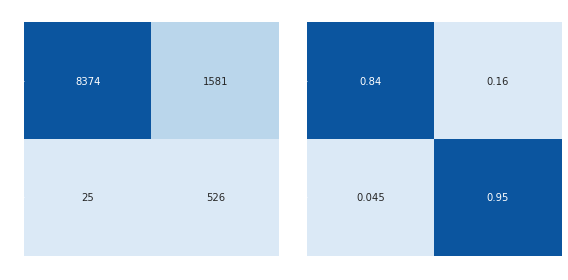

In [23]:
cm = confusion_matrix(y, pipe_gb_best.predict(X_dum))
cm_norm = confusion_matrix(y, pipe_gb_best.predict(X_dum), normalize='true')

classes = pipe_gb_best.classes_

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, fmt='d', cbar=False,
            cmap=sns.color_palette("Blues"), ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].title.set_color('white')

sns.heatmap(pd.DataFrame(cm_norm, index=classes, columns=classes), annot=True, cbar=False,
            cmap=sns.color_palette("Blues"), ax=ax[1])
ax[1].set_title('Normalized Confusion Matrix')

ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].title.set_color('white')

plt.tight_layout();

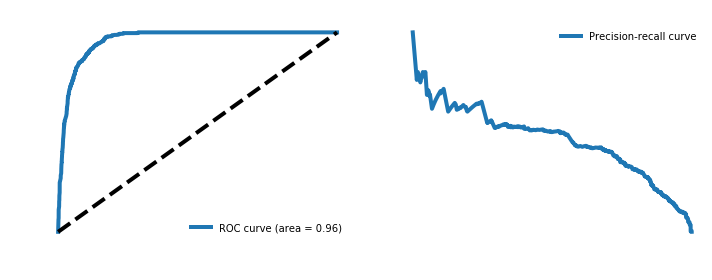

In [24]:
y_pp = pd.DataFrame(pipe_gb_best.predict_proba(X_dum), columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc="lower right")
ax[0].set_title('ROC curve')

ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].title.set_color('white')

ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('white')
ax[0].spines['left'].set_color('white')
ax[0].spines['right'].set_color('white')

# PR curve
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

ax[1].plot(recall, precision, label='Precision-recall curve', linewidth=4)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].title.set_color('white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[1].spines['right'].set_color('white')

legend = ax[0].legend(frameon = 1)
frame = legend.get_frame()
frame.set_color('white')

legend = ax[1].legend(frameon = 1)
frame = legend.get_frame()
frame.set_color('white')

fig.savefig('gb_roc.png', transparent=True, edgecolor='white')

plt.tight_layout()
plt.show()

In [ ]:
# Pickle if results are satisfactory:
gs_gb_pickle_name = './pickle_objects/gs_gb_best_score_{}%.pkl'.format(np.round(gs_gb.best_score_*100,2))
pickle.dump(gs_gb.best_estimator_, open(gs_gb_pickle_name, 'wb'))

#### Naive Bayes Classifier

In [ ]:
pt = PowerTransformer(standardize=True)
X_dum_pt = pd.DataFrame(pt.fit_transform(X_dum), columns=X_dum.columns, index=X_dum.index)

fig,ax = plt.subplots(ncols=2, figsize=(10,4))
X_dum.loc[:,'weather_PC1':'weather_PC10'].boxplot(vert=False, ax=ax[0]);
ax[0].set_title('Continuous variables')
X_dum_pt.loc[:,'weather_PC1':'weather_PC10'].boxplot(vert=False, ax=ax[1]);
ax[1].set_title('Normalized Continuous variables')
plt.tight_layout();

In [ ]:
sm_nb_gaussian = SMOTE()
ovr = RandomOverSampler()

# GaussianNB for continuous features:
nb_gaussian = naive_bayes.GaussianNB()
params = {'nb_gaussian__var_smoothing':np.logspace(-10,0,5)}
    
pipeline = Pipeline([('std', std), ('sm_nb_gaussian', sm_nb_gaussian), ('nb_gaussian', nb_gaussian)])

gs_nb_gaussian = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_nb_gaussian.fit(X_dum_pt.loc[:,'weather_PC1':'weather_PC10'], y)
print(gs_nb_gaussian.best_params_)
print(gs_nb_gaussian.best_score_)

# MultinomialNB for categorical features:
nb_multinomial = naive_bayes.MultinomialNB()
params = {'nb_multinomial__alpha':np.linspace(0.1,1.0,5)}

pipeline = Pipeline([('ovr', ovr),
                     ('nb_multinomial', nb_multinomial)])

X_dum_multinb = pd.get_dummies(X[['Species','Trap']])

gs_nb_multinomial = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_nb_multinomial.fit(X_dum_multinb, y)
print(gs_nb_multinomial.best_params_)
print(gs_nb_multinomial.best_score_)

# BernoulliNB for binary features:
nb_bernoulli = naive_bayes.BernoulliNB()
params = {'nb_bernoulli__alpha':np.linspace(0.1,1.0,5)}

pipeline = Pipeline([('ovr', ovr),
                     ('nb_bernoulli', nb_bernoulli)])

gs_nb_bernoulli = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_nb_bernoulli.fit(X[['isSpray']], y)
print(gs_nb_bernoulli.best_params_)
print(gs_nb_bernoulli.best_score_)

# Combining Naive Bayes classifiers:


In [ ]:
nb_gaussian_best = naive_bayes.GaussianNB(var_smoothing=1.0)
pipeline_best_nb_gau = Pipeline([('std', std), ('sm_nb_gaussian', sm_nb_gaussian), ('nb_gaussian_best', nb_gaussian_best)])

pipeline_best_nb_gau.fit(X_dum_pt.loc[:,'weather_PC1':'weather_PC10'], y)
a_gau = pipeline_best_nb_gau.predict_proba(X_dum_pt.loc[:,'weather_PC1':'weather_PC10'])
a_gau

In [ ]:
nb_bernoulli_best = naive_bayes.BernoulliNB(alpha=0.1)
pipeline_best_nb_ber = Pipeline([('ovr' , ovr), ('nb_bernoulli_best', nb_bernoulli_best)])
pipeline_best_nb_ber.fit(X[['isSpray']], y)
a_ber = pipeline_best_nb_ber.predict_proba(X[['isSpray']])
a_ber

In [ ]:
nb_multinomial_best = naive_bayes.MultinomialNB(alpha=1.0)
pipeline_best_nb_mul = Pipeline([('ovr' , ovr), ('nb_multinomial_best', nb_multinomial_best)])
pipeline_best_nb_mul.fit(X_dum_multinb, y)
a_mul = pipeline_best_nb_mul.predict_proba(X_dum_multinb)
a_mul

#### Support Vector Machines

In [ ]:
svm = SVC(kernel='rbf')
params = {'svm__C':np.logspace(-4,4,5),
          'svm__gamma':np.logspace(-4,4,5)}
    
pipeline = Pipeline([('std', std), ('sm', sm), ('svm', svm)])

gs_svm = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_svm.fit(X_dum, y)
print(gs_svm.best_params_)
print(gs_svm.best_score_)

In [ ]:
# Pickle if results are satisfactory:
gs_svm_pickle_name = './pickle_objects/gs_svm_best_score_{}%.pkl'.format(np.round(gs_svm.best_score_*100,2))
pickle.dump(gs_svm.best_estimator_, open(gs_svm_pickle_name, 'wb'))

### Append predicts

In [25]:
# Reload .pkl objects on restart:
Tk().withdraw()
pipe_lr_best = pickle.load(open(askopenfilename(), 'rb'))
# pipe_dt_best = pickle.load(open(askopenfilename(), 'rb'))
# pipe_rf_best = pickle.load(open(askopenfilename(), 'rb'))
pipe_bc_best = pickle.load(open(askopenfilename(), 'rb'))
# pipe_gb_best = pickle.load(open(askopenfilename(), 'rb'))

In [26]:
train_predict_df = pd.read_csv('./datasets/train_predict_df.csv')
# train_predict_df = train_df.copy()
pipe_lr_best.fit(X_dum, y)
train_predict_df['lr_predict'] = pipe_lr_best.predict(X_dum)
# pipe_dt_best.fit(X_dum, y)
# train_predict_df['dt_predict'] = pipe_dt_best.predict(X_dum)
# pipe_rf_best.fit(X_dum, y)
# train_predict_df['rf_predict'] = pipe_rf_best.predict(X_dum)
pipe_bc_best.fit(X_dum, y)
train_predict_df['bc_predict'] = pipe_bc_best.predict(X_dum)
# pipe_gb_best.fit(X_dum, y)
# train_predict_df['gb_predict'] = pipe_gb_best.predict(X_dum)
train_predict_df.to_csv('./datasets/train_predict_df.csv')

/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (23,31,33,89) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
def vs_actual_labeller(df):
    if df.iloc[0] and df.iloc[1]:
        label = 'VirusCaught'
    elif df.iloc[0] and not df.iloc[1]:
        label = 'VirusMissed'
    elif not df.iloc[0] and df.iloc[1]:
        label = 'FalseAlarm'
    else:
        label = 'NoVirus'
    return label

In [28]:
train_predict_df = pd.read_csv('./datasets/train_predict_df.csv')

train_predict_df['lr_vs_actual'] = train_predict_df[['WnvPresent','lr_predict']].apply(vs_actual_labeller, axis=1)
#train_predict_df['dt_vs_actual'] = train_predict_df[['WnvPresent','dt_predict']].apply(vs_actual_labeller, axis=1)
#train_predict_df['rf_vs_actual'] = train_predict_df[['WnvPresent','rf_predict']].apply(vs_actual_labeller, axis=1)
train_predict_df['bc_vs_actual'] = train_predict_df[['WnvPresent','bc_predict']].apply(vs_actual_labeller, axis=1)
#train_predict_df['gb_vs_actual'] = train_predict_df[['WnvPresent','gb_predict']].apply(vs_actual_labeller, axis=1)

train_predict_df.to_csv('./datasets/train_predict_df.csv')

/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (24,32,34,90) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### TensorFlow Keras Neural Network

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
metric = tf.keras.metrics.AUC()

def create_model(epochs, optimizer, batch_size, kernel_initializer_fn, kernel_regularizer_fn):
    tf_keras = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(X_dum.shape[1], )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')])
    
    tf_keras.compile(loss='binary_crossentropy',
                     optimizer=optimizer,
                     metrics=[metric])
    return tf_keras

In [ ]:
kerasclf = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)
params = {'kerasclf__epochs': [100],
          'kerasclf__optimizer': ['sgd','adam'],
          'kerasclf__batch_size': [5, 10, 20],
          'kerasclf__kernel_initializer_fn': ['glorot_uniform', 'normal', 'uniform'],
          'kerasclf__kernel_regularizer_fn': ['L1L2']}
          
pipeline = Pipeline([('std', std), ('sm', sm), ('kerasclf', kerasclf)])

gs_keras = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_keras.fit(X_dum, y)
print(gs_keras.best_params_)
print(gs_keras.best_score_)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

model = create_model(epochs=gs_keras.best_params_['kerasclf__epochs'],
                     optimizer=gs_keras.best_params_['kerasclf__optimizer'],
                     batch_size=gs_keras.best_params_['kerasclf__batch_size'],
                     kernel_initializer_fn=gs_keras.best_params_['kerasclf__kernel_initializer_fn'],
                     kernel_regularizer_fn=gs_keras.best_params_['kerasclf__kernel_regularizer_fn'],)

history = model.fit(X_dum, y.values,
                    epochs=gs_keras.best_params_['kerasclf__epochs'],
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop])

In [ ]:
plt.plot(history.history['loss'],c='r')
plt.plot(history.history['val_loss'],c='b')
plt.show()

## Kaggle Submission

#### Setting up (X_test)

In [ ]:
X_test = test_df[['Species','Trap','weather_PC1','weather_PC2','weather_PC3','weather_PC4','weather_PC5',
                  'weather_PC6','weather_PC7','weather_PC8','weather_PC9','weather_PC10','isSpray']]
X_test_dum = pd.get_dummies(X_test, drop_first=True, columns=['Species','Trap'])

#### Model predictions

In [ ]:
X_dum.head(1)

In [ ]:
X_test_dum.head(1)

In [ ]:
pipe_gb_best.fit(X_dum, y)
y_test_pp = pd.DataFrame(pipe_gb_best.predict_proba(X_test_dum), columns=['class_0_pp', 'class_1_pp'])

In [ ]:
# Submit to kaggle
# Add sampling strategy as hyperparameter in gridsearches
# How can I combine the NB classifiers?
# Keras - plot acc as well as loss. like calum